### load the data

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.0


In [21]:
data = pd.read_csv('fer2013.csv')

In [22]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [23]:
data.isnull().any() # no missing data, good

emotion    False
pixels     False
Usage      False
dtype: bool

### EDA

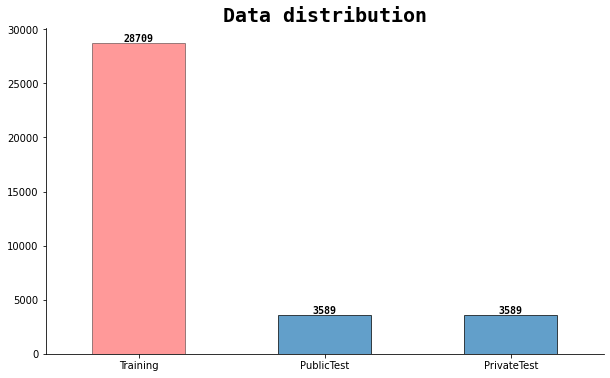

In [24]:
data['Usage'].value_counts().plot.bar(alpha=0.7, edgecolor='black')
ax = plt.gca()
for i in ax.containers:
    plt.bar_label(i, font='monospace', weight='semibold')
plt.xticks(rotation=360)
ax.get_children()[0].set_color('red')
ax.get_children()[0].set_alpha(0.4)
ax.get_children()[0].set_edgecolor('black')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.title('Data distribution', size=20, weight='semibold', font='monospace')
ax.spines[['right', 'top']].set_visible(False);

In [25]:
scale = {0:'Angry', 1:'Digust', 2:'Fear', 3:'Happy', 4:'Sad',5:'Surprise',6:'Neutral'}

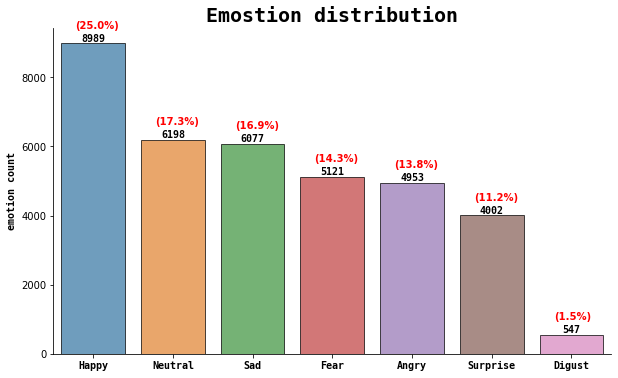

In [26]:
emotion = data['emotion'].replace(scale).value_counts().reset_index()
sns.barplot(emotion, x='index', y='emotion', alpha=0.7, edgecolor='black')
plt.xlabel('')
plt.ylabel('emotion count', font='monospace', weight='semibold')
ax = plt.gca()
for i in ax.get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
for i in ax.containers:
    plt.bar_label(i, font='monospace', weight='semibold')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.title('Emostion distribution', font='monospace', weight='semibold',size=20)
for p in ax.patches:
    pct = f'({100*(p.get_height()/float(len(data))):0.1f}%)\n'
    ax.annotate(pct, (p.get_x()+p.get_width()/4.5, p.get_height()+100), color='r', weight='semibold')
ax.spines[['right', 'top']].set_visible(False)

In [27]:
def reshape_data(x):
    img = np.array(x.split()).reshape(48,48).astype(int)
    return img

In [28]:
df = data['pixels'].apply(reshape_data)

In [29]:
df.shape 

(35887,)

In [30]:
np.array(df.tolist()).shape # or we can turn df into a numpy array

(35887, 48, 48)

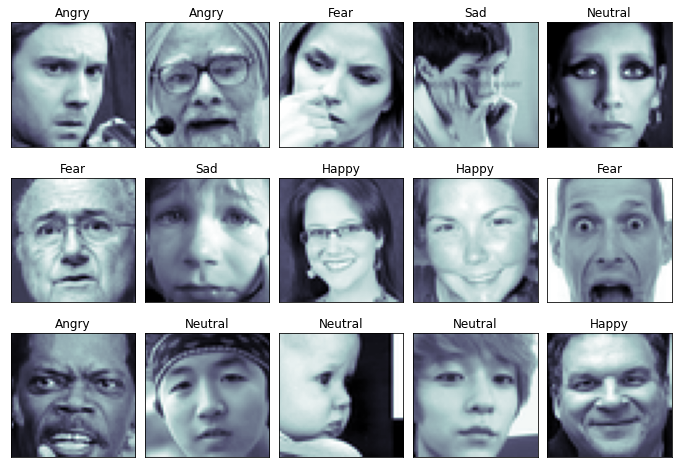

In [31]:
fig,axes = plt.subplots(3,5, figsize=(12,8), gridspec_kw=dict(hspace=0.25, wspace=0.01), subplot_kw=dict(xticks=[], yticks=[]))
for i, ax in enumerate(axes.flat):
    ax.imshow(df[i], cmap='bone')
    ax.set_title(data['emotion'].replace(scale)[i])
    

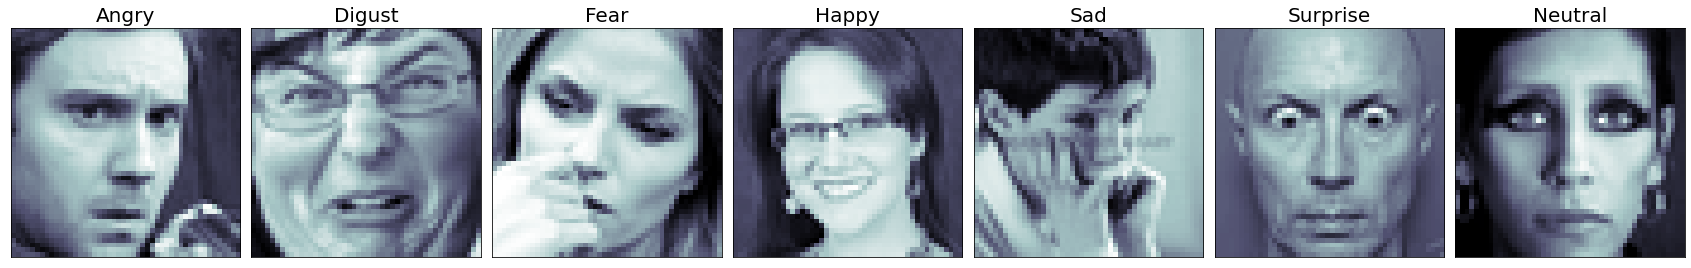

In [32]:
fig, axes = plt.subplots(1,7, figsize=(30,5), subplot_kw=dict(xticks=[],yticks=[]), gridspec_kw=dict(hspace=0.05, wspace=0.05))
for i, ax in enumerate(axes.flat):
    ax.imshow(data[data['emotion']==i]['pixels'].apply(reshape_data).iloc[0], cmap='bone')
    ax.set_title(scale.get(i), size=20)

### pre-processing

In [33]:
train = data[data['Usage']=='Training'].copy()
val = data[data['Usage']=='PublicTest'].copy()
test = data[data['Usage']=='PrivateTest'].copy()

In [34]:
print(f'train:{train.shape}\nval:{val.shape}\ntest:{test.shape}')

train:(28709, 3)
val:(3589, 3)
test:(3589, 3)


In [35]:
def emotion_distribution(ax, data, title):
    emotion = data['emotion'].replace(scale).value_counts().reset_index()
    sns.barplot(emotion, x='index', y='emotion', alpha=0.7, edgecolor='black', ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('emotion count', font='monospace', weight='semibold')
    for i in ax.get_xticklabels():
        i.set_font('monospace')
        i.set_weight('semibold')
    for j in ax.containers:
        ax.bar_label(j, font='monospace', weight='semibold')
    ax.set_title(f'{title} Emostion Distribution', font='monospace', weight='semibold')

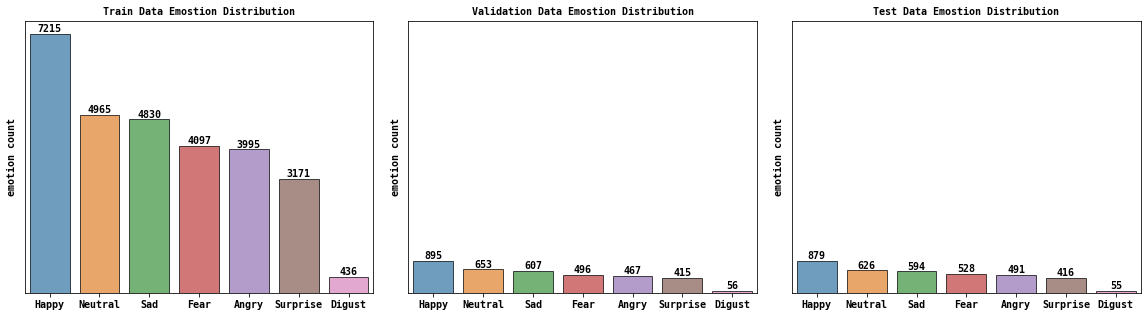

In [36]:
fig, axes = plt.subplots(1,3,sharey=True,sharex=True, figsize=(20,5), subplot_kw=dict(xticks=[],yticks=[]), gridspec_kw=dict(wspace=0.1))
emotion_distribution(axes[0],train, 'Train Data')
emotion_distribution(axes[1],val, 'Validation Data')
emotion_distribution(axes[2],test, 'Test Data')

In [37]:
def preprocessing(data):
    X = np.array(data['pixels'].apply(lambda x: [int(i) for i in x.split()]).tolist()).reshape(-1, 48,48,1)/255
    y = to_categorical(data['emotion'], 7)
    return X,y

In [38]:
Xtrain, ytrain = preprocessing(train)
Xval, yval = preprocessing(val)
Xtest, ytest = preprocessing(test)

In [39]:
print(f'Xtrain_shape:{Xtrain.shape}\nXval_shape:{Xval.shape}\nXtest_shape:{Xtest.shape}')

Xtrain_shape:(28709, 48, 48, 1)
Xval_shape:(3589, 48, 48, 1)
Xtest_shape:(3589, 48, 48, 1)


### build the model

##### Reference: Inthiyaz, S., Parvez, M. M., Kumar, M. S., sai Srija, J. S., Sai, M. T., & Vardhan, V. A. (2021, February). Facial Expression Recognition Using KERAS. In Journal of Physics: Conference Series (Vol. 1804, No. 1, p. 012202). IOP Publishing.

In [50]:
model = Sequential()

model.add(Conv2D(64, (3,3),  padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5),  padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3),  padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3),  padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_30 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 128)      

### train the model and do model validation

In [54]:
data_gen = ImageDataGenerator(horizontal_flip=True)
train_generator = data_gen.flow(Xtrain, ytrain, batch_size=64)

data_gen = ImageDataGenerator(horizontal_flip=True)
validation_generator = data_gen.flow(Xval, yval, batch_size=64)

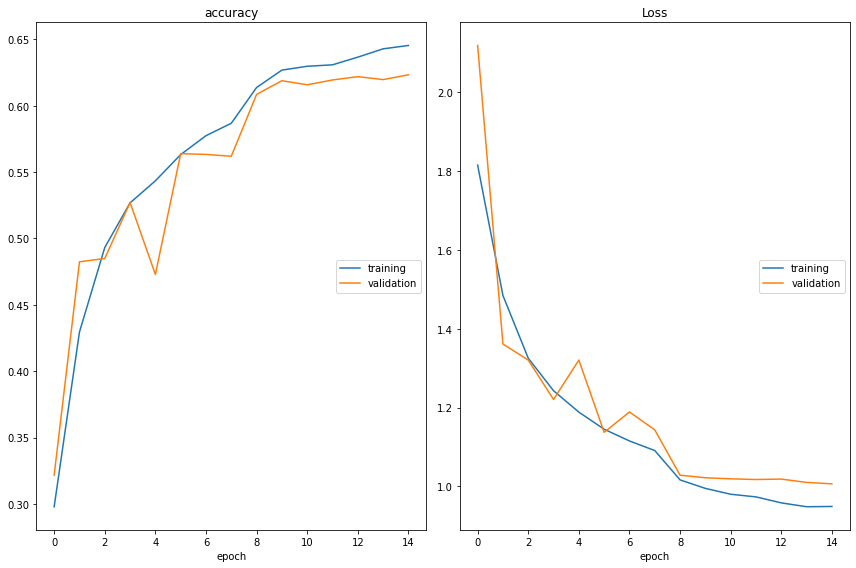

accuracy
	training         	 (min:    0.298, max:    0.645, cur:    0.645)
	validation       	 (min:    0.322, max:    0.623, cur:    0.623)
Loss
	training         	 (min:    0.948, max:    1.816, cur:    0.949)
	validation       	 (min:    1.006, max:    2.119, cur:    1.006)

Epoch 15: saving model to model_weights.h5
448/448 [==============================] - 384s 857ms/step - loss: 0.9488 - accuracy: 0.6454 - val_loss: 1.0063 - val_accuracy: 0.6233 - lr: 5.0000e-05


In [57]:
epochs = 15
steps_per_epoch = train_generator.n//64
validation_steps = validation_generator.n//64

checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy',
                            save_weight_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
callbacks=[PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(x = train_generator, steps_per_epoch = steps_per_epoch,
                   epochs=epochs,
                   validation_data=validation_generator,
                   validation_steps=validation_steps,
                   callbacks=callbacks)

### make a predction

In [65]:
pred = np.argmax(model.predict(Xtest), axis=1)

113/113 [==============================] - 11s 95ms/step


In [76]:
print(classification_report(np.argmax(ytest,axis=1), pred))

              precision    recall  f1-score   support

           0       0.60      0.55      0.58       491
           1       0.53      0.45      0.49        55
           2       0.51      0.33      0.40       528
           3       0.86      0.85      0.86       879
           4       0.47      0.61      0.53       594
           5       0.72      0.81      0.77       416
           6       0.62      0.62      0.62       626

    accuracy                           0.65      3589
   macro avg       0.62      0.61      0.61      3589
weighted avg       0.65      0.65      0.64      3589



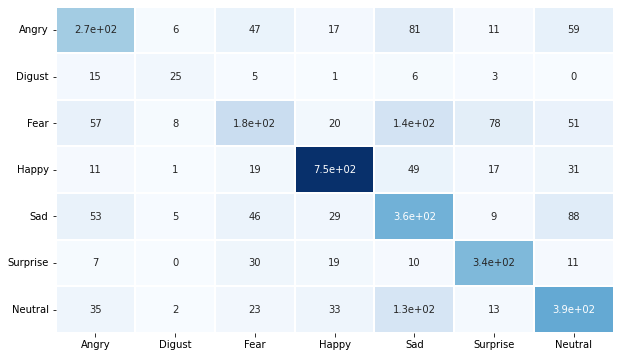

In [97]:
sns.heatmap(confusion_matrix(np.argmax(ytest,axis=1), pred), cmap='Blues', cbar=False, xticklabels=[i[1] for i in scale.items()],
           yticklabels = [i[1] for i in scale.items()], annot=True, linewidth=0.01)
fig = plt.gcf()
fig.set_size_inches(10,6)

### Represet model as JSON string

In [100]:
model_json = model.to_json()
with open('model_json', 'w') as json_file:
    json_file.write(model_json)